# MBWU Evaluation

{5: {'device_ios': {'mean': 2235.5855587893016, 'stdev': 16.31807645445985}, 'device_mbs': {'mean': 96.48096173512933, 'stdev': 0.8632087417342098}, 'ycsb_throughput': {'mean': 6050.626202343374, 'stdev': 54.654582009776}}, 10: {'device_ios': {'mean': 3098.2727398736215, 'stdev': 40.0928960198829}, 'device_mbs': {'mean': 130.07259048250688, 'stdev': 1.3178286062216569}, 'ycsb_throughput': {'mean': 8696.450589331662, 'stdev': 119.56020335826398}}, 21: {'device_ios': {'mean': 3868.045410946418, 'stdev': 13.910808881627224}, 'device_mbs': {'mean': 160.94245628132407, 'stdev': 0.484614303741052}, 'ycsb_throughput': {'mean': 10858.07637116784, 'stdev': 85.22089026870806}}, 25: {'device_ios': {'mean': 4052.9514798897335, 'stdev': 25.218470504225987}, 'device_mbs': {'mean': 164.8120299765172, 'stdev': 0.8449618598277638}, 'ycsb_throughput': {'mean': 11258.293365083313, 'stdev': 72.6416573058462}}, 3: {'device_ios': {'mean': 1649.5665590248736, 'stdev': 14.52216086889124}, 'device_mbs': {'mean

Text(0.5, 1.12, 'MBWU Evaluation Results')

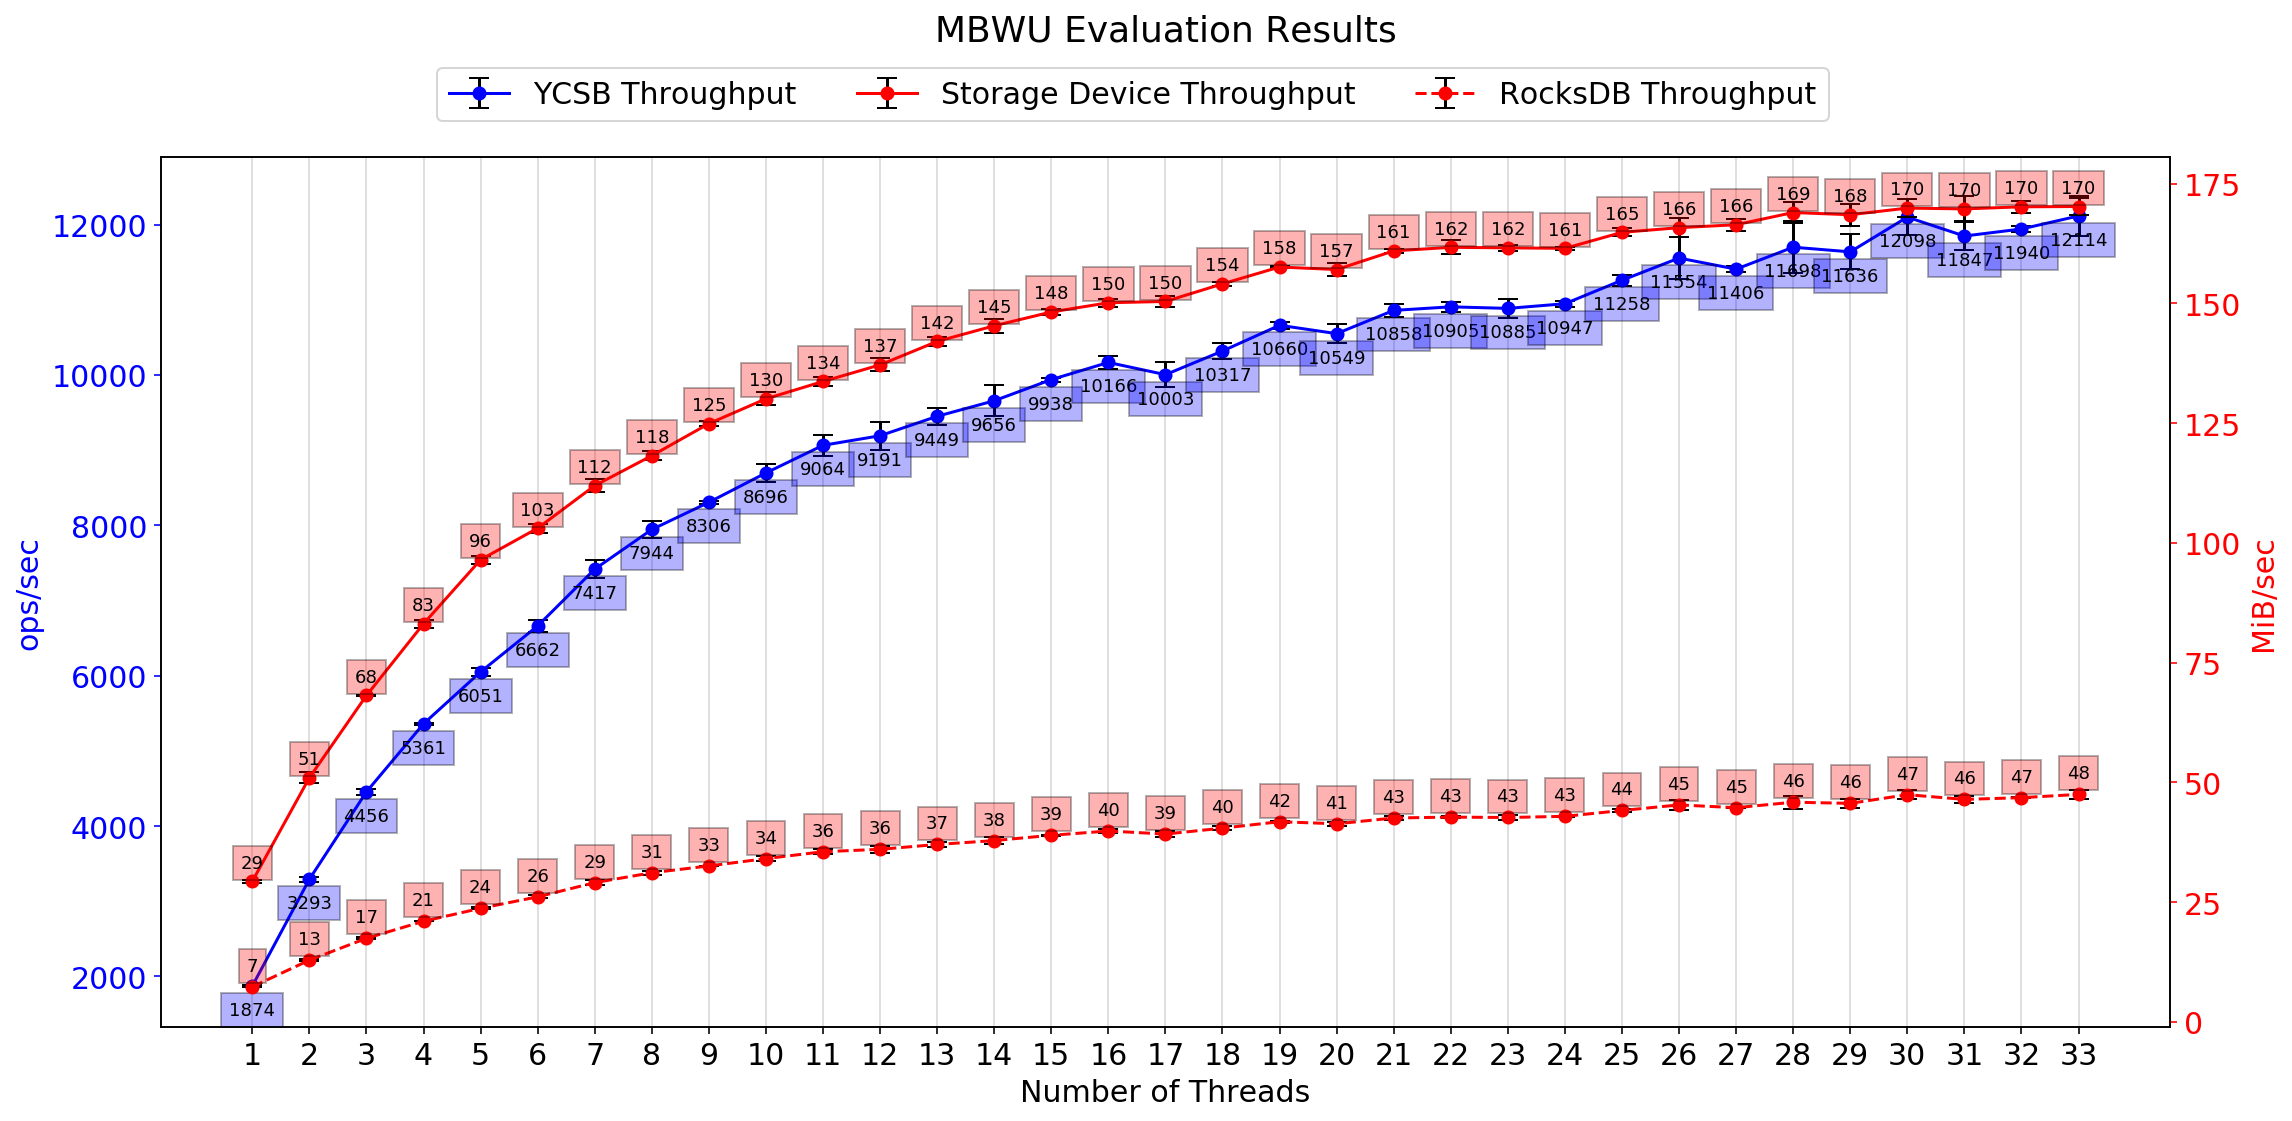

In [1]:
import json
import re
import os
import subprocess


DIR_BASE = 'data/ycsb/myworkloada/THNSNJ128G8NU/MBWU'
thread_folders = os.listdir(DIR_BASE)

data_points = {}

for folder in thread_folders:
    num_threads = int(re.search(r'(\d+)_threads', folder).group(1))
    
    process = subprocess.run(['scripts/get_thread_data.py', os.path.join(DIR_BASE, folder)],
                   capture_output=True, check=True, universal_newlines=True)
    data_points[num_threads] = json.loads(process.stdout)
    

# show data points
print(data_points)

# start to plot figure

##################  TEMPLATE  ##################

import matplotlib
import matplotlib.pyplot as plt

# Double resolution plot output for retina screens.
# Just be aware that this won’t render on non-retina screens.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

matplotlib.rcParams['figure.figsize'] = [18, 8]
matplotlib.rcParams["font.size"] = 15

fig, ax = plt.subplots()

def __update_color(bar):
    ax = bar.figure.gca()
    ax.tick_params(axis='y', colors=bar.get_color())
    ax.yaxis.label.set_color(bar.get_color())
    
def __autolabel(bar, verticalalignment='bottom'):
    """
    Attach a text label above each point displaying its value
    """
    ax = bar.figure.gca()
    
    yticks = ax.get_yticks()
    pos_delta = (yticks[1] - yticks[0]) * 0.1
    
    xydata = bar.get_xydata()
    
    for xy in xydata:
        height = xy[1]
        if verticalalignment == 'bottom':
            height += pos_delta
        elif verticalalignment == 'top':
            height -= pos_delta

        ax.text(xy[0], height,
                '%.0f' % xy[1],
                ha='center', va=verticalalignment, size=9,
                bbox=dict(facecolor=bar.get_color(), alpha=0.3))

##################  TEMPLATE  ##################


ax.set_ylabel('ops/sec')
ax.set_xlabel('Number of Threads')
ax.xaxis.grid(alpha=0.5)

xticks = sorted(data_points.keys())

ycsb_throughput_bar, *_ = ax.errorbar(
    xticks,
    [data_points[tick]['ycsb_throughput']['mean'] for tick in xticks],
    yerr=[data_points[tick]['ycsb_throughput']['stdev'] for tick in xticks],
    color='blue',
    marker='o',
    capsize=5,
    capthick=1,
    ecolor='black',
    label='YCSB Throughput')
__update_color(ycsb_throughput_bar)
__autolabel(ycsb_throughput_bar, 'top')


ax_mbs = ax.twinx()
ax_mbs.set_ylabel('MiB/sec')

device_throughput_bar, *_ = ax_mbs.errorbar(
    xticks,
    [data_points[tick]['device_mbs']['mean'] for tick in xticks],
    yerr=[data_points[tick]['device_mbs']['stdev'] for tick in xticks],
    color='red',
    marker='o',
    capsize=5,
    capthick=1,
    ecolor='black',
    label='Storage Device Throughput')
__update_color(device_throughput_bar)
__autolabel(device_throughput_bar)


_VALUE_SIZE_BYTES = 4 * 1024
_KEY_SIZE_BYTES = 16

factor = (_VALUE_SIZE_BYTES + _KEY_SIZE_BYTES) / 1024 / 1024

rocksdb_throughput_bar, *_ = ax_mbs.errorbar(
    xticks,
    [data_points[tick]['ycsb_throughput']['mean'] * factor for tick in xticks],
    yerr=[data_points[tick]['ycsb_throughput']['stdev'] * factor for tick in xticks],
    color='red',
    ls='--',
    marker='o',
    capsize=5,
    capthick=1,
    ecolor='black',
    label='RocksDB Throughput')
__update_color(rocksdb_throughput_bar)
__autolabel(rocksdb_throughput_bar)


fig.legend(loc="upper center",
           bbox_to_anchor=(0.5, 0.97),
           ncol=3,
           bbox_transform=fig.transFigure)
plt.xticks(xticks)
plt.title('MBWU Evaluation Results', y=1.12)